Importing Library

In [25]:
import numpy as np
import matplotlib.pyplot as plt

Loading Data

In [26]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_images.shape

(10000, 28, 28)

Flatten Layer

In [27]:
def Flattening (data):
    return data.reshape(data.shape[0], data.shape[1]*data.shape[2])
train_images_flat = Flattening(train_images)     
train_images_flat.shape

(60000, 784)

Batch Normalization Layer: normalizes the activations of the previous layer for each mini-batch, keeping the mean close to 0 and the variance close to 1.

In [28]:
#Chuẩn hóa các dữ liệu đầu vào, nằm giữa các fully connected layer / convo
class BatchNorm:
    def __init__(self, hidden_size): #hidden_size = size of data
        self.hidden_size = hidden_size
        self.x = None
        self.gamma = np.ones((hidden_size, 1))  # initialize gamma = array of 1
        self.beta = np.zeros((hidden_size, 1))  # initialize beta = array of 0

    def forward(self, x):
        self.x = x
        self.mu = np.mean(x, axis = 0)
        self.var = np.var(x, axis=0)
        self.x_norm = (x - self.mu) / np.sqrt(self.var + 1e-6) # constant = 1e-6
        out = self.gamma * self.x_norm + self.beta
        return out

    def plot_batch_norm(self):
        # Compute the histograms of the pre-normalized and post-normalized data
        pre_norm_hist, pre_norm_bins = np.histogram(self.x, bins=30)
        post_norm_hist, post_norm_bins = np.histogram(self.x_norm, bins=30)

        # Plot the pre-normalized data
        plt.hist(pre_norm_bins[:-1], pre_norm_bins, weights=pre_norm_hist, alpha=0.5, label='Pre-Normalization')

        # Plot the post-normalized data
        plt.hist(post_norm_bins[:-1], post_norm_bins, weights=post_norm_hist, alpha=0.5, label='Post-Normalization')
        
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title('Pre-Normalization vs. Post-Normalization')
        plt.legend()

        # Display the plot
        plt.show()

    def plot_activation_distribution(self, activation_function):
        # Compute the activation before batch normalization
        pre_norm_activation = activation_function(self.x)

        # Compute the activation after batch normalization
        post_norm_activation = activation_function(self.x_norm)

        # Compute the histograms of the pre-normalized and post-normalized activations
        pre_norm_hist, pre_norm_bins = np.histogram(pre_norm_activation, bins=30)
        post_norm_hist, post_norm_bins = np.histogram(post_norm_activation, bins=30)

        # Plot the pre-normalized activation
        plt.hist(pre_norm_bins[:-1], pre_norm_bins, weights=pre_norm_hist, alpha=0.5, label='Pre-Normalization')

        # Plot the post-normalized activation
        plt.hist(post_norm_bins[:-1], post_norm_bins, weights=post_norm_hist, alpha=0.5, label='Post-Normalization')

        # Add labels, a title, and a legend
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.title('Activation Distribution: Pre-Normalization vs. Post-Normalization')
        plt.legend()

        # Display the plot
        plt.show()

Visualizing Batch Normalization Layer

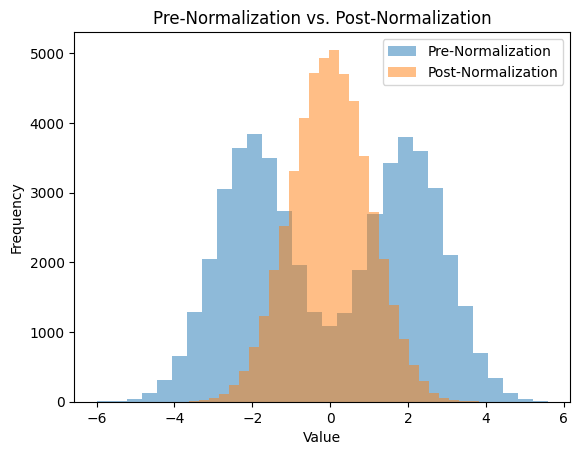

In [32]:
# Create an instance of BatchNorm with a hypothetical hidden size, for example, 50.
bn_layer = BatchNorm(50)

# Pass some data from a mixture of Gaussians through the BatchNorm layer
# Generate data from two different normal distributions and combine them
data1 = np.random.normal(-2, 1, size=(500, 50))
data2 = np.random.normal(2, 1, size=(500, 50))
data = np.concatenate([data1, data2])

bn_layer.forward(data.T)

# Now, call the visualization methods
bn_layer.plot_batch_norm()

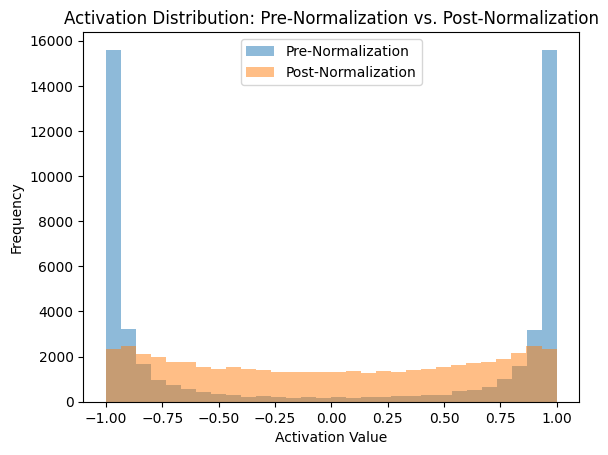

In [33]:
# Create an instance of BatchNorm with a hypothetical hidden size, for example, 50.
bn_layer = BatchNorm(50)

bn_layer.forward(data.T)

# Now, call the visualization methods
bn_layer.plot_activation_distribution(np.tanh)  # Use the tanh activation function

Visualizing Batch Normalization Layer On One Layer From The MNIST Dataset

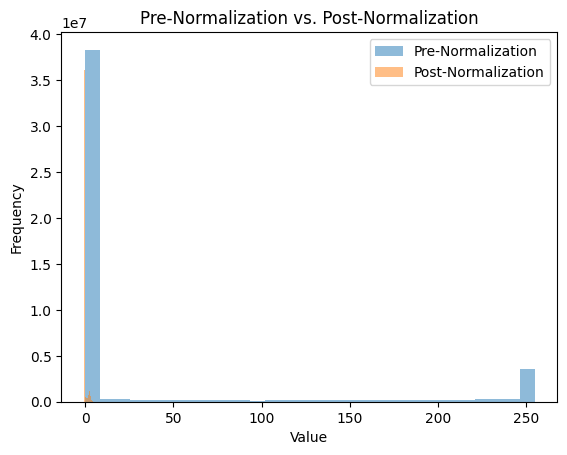

In [29]:
# Create an instance of BatchNorm with a hypothetical hidden size, for example, 50.
bn_layer = BatchNorm(28*28)
bn_layer.forward(train_images_flat.T)

# Now, call the visualization methods
bn_layer.plot_batch_norm()

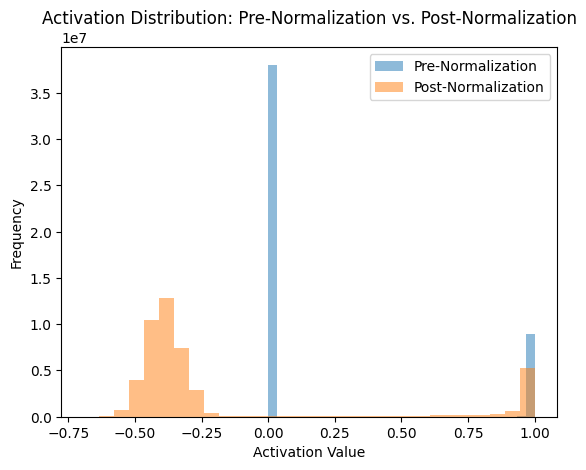

In [30]:
# Create an instance of BatchNorm with a hypothetical hidden size, for example, 50.
bn_layer = BatchNorm(28*28)

bn_layer.forward(train_images_flat.T)

# Now, call the visualization methods
bn_layer.plot_activation_distribution(np.tanh)  # Use the tanh activation function

Drop Out layer: cannot rely on any one feature, so have to spread out weights. Prevent overfitting

In [31]:
class Dropout:
    

SyntaxError: incomplete input (4177162961.py, line 2)